## Packages

In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Loading the Data

In [3]:
raw_data = yfinance.download(
    tickers = '^GSPC ^FTSE ^N225 ^GDAXI',
    start = '1994-01-07', end = '2019-09-01',
    interval = '1d', group_by = 'ticker',
    auto_adjust = True, treads = True
)

[*********************100%***********************]  4 of 4 completed


In [4]:
df_comp = raw_data.copy()

In [5]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [6]:
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
del df_comp['^N225']
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

## Creating Returns

In [7]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [8]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1]) * 100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1]) * 100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax) * 100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei) * 100

## Splitting the Data

In [9]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [10]:
# AR(1) model
model_ar = ARIMA(df.ftse, order = (1, 0, 0))
results_ar = model_ar.fit()

## Simple Forecasting

In [11]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,100.0,100.0
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,100.0,100.0
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,100.0,100.0
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,100.0,100.0
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,100.0,100.0


In [12]:
# Create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = '2014-07-15'
end_date = '2015-01-01'

In [13]:
df_pred = results_ar.predict(start = start_date, end = end_date)

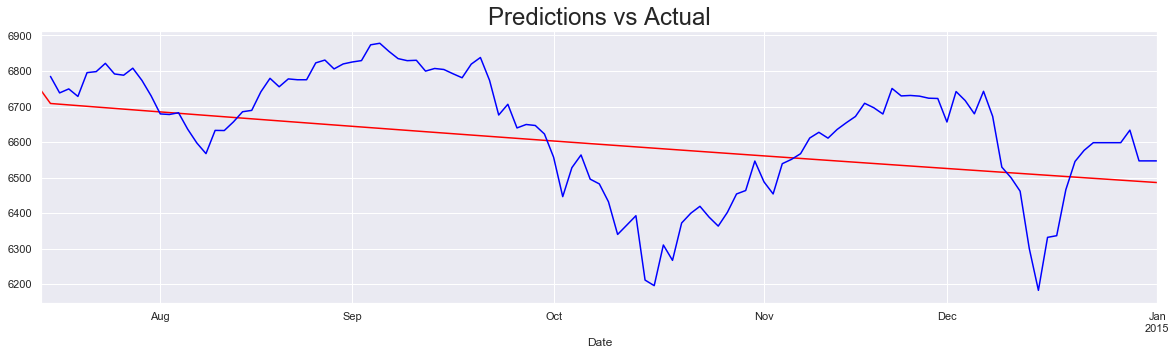

In [14]:
df_pred[start_date:end_date].plot(figsize = (20, 5), color = 'red')
df_test.ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual', size = 24)
plt.show()
# The issue comes from our model of choice
# The predictions are only based on the constant and the prices from the previous period
# Every new value is just a fraction of the previou sone put on top of the constant term
# The AR model is so bad at estimating non-stationary data

## Using Returns Instead

In [15]:
model_ret_ar = ARIMA(df.ret_ftse[1:], order = (1, 0, 0))
results_ret_ar = model_ret_ar.fit()

In [16]:
df_pred_ret_ar = results_ret_ar.predict(start = start_date, end = end_date)

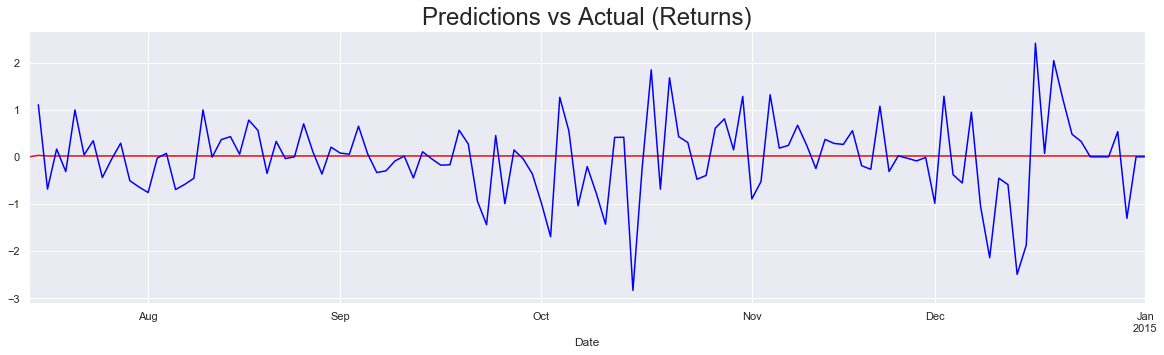

In [18]:
df_pred_ret_ar[start_date:end_date].plot(figsize = (20, 5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()
# Our model makes no predictions since it assumes all future returns will be 0, or extremely close to it.

In [19]:
results_ret_ar.summary()
# Notice how the coefficients are not significant

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 0)   Log Likelihood               -8344.717
Method:                       css-mle   S.D. of innovations              1.151
Date:                Wed, 17 Feb 2021   AIC                          16695.434
Time:                        21:17:37   BIC                          16715.189
Sample:                    01-11-1994   HQIC                         16702.334
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0191      0.015      1.243      0.214      -0.011       0.049
ar.L1.ret_ftse    -0.0231      0.014     -1.692      0.091      -0.050       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.2413           +0.0000j           43.2413            0.5000
-----------------------------------------------------------------------------
"""

## MA

In [20]:
model_ret_ma = ARIMA(df.ret_ftse[1:], order = (0, 0, 1))
results_ret_ma = model_ret_ma.fit()

In [21]:
df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date)

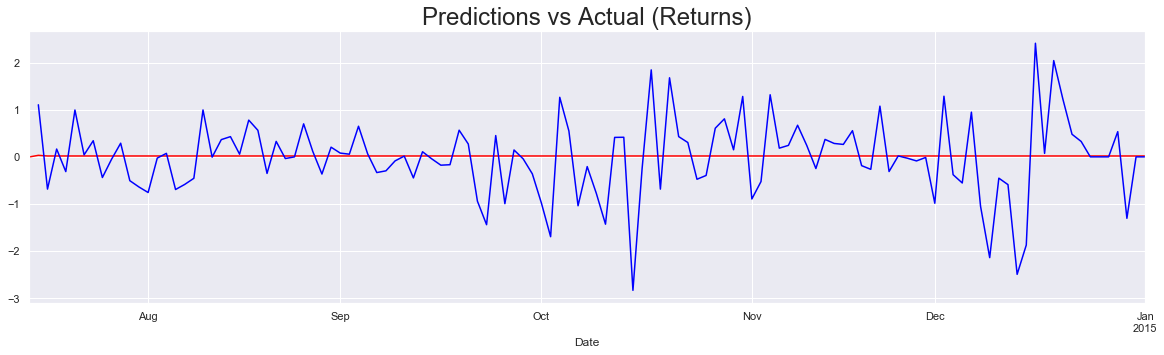

In [22]:
df_pred_ma[start_date:end_date].plot(figsize = (20, 5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

In [23]:
df_pred_ma.head()

2014-07-15   -0.002086
2014-07-16    0.032676
2014-07-17    0.019121
2014-07-18    0.019121
2014-07-21    0.019121
Freq: B, dtype: float64

## ARMA

In [24]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order = (1, 0, 1))
results_ret_arma = model_ret_arma.fit()

In [25]:
df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

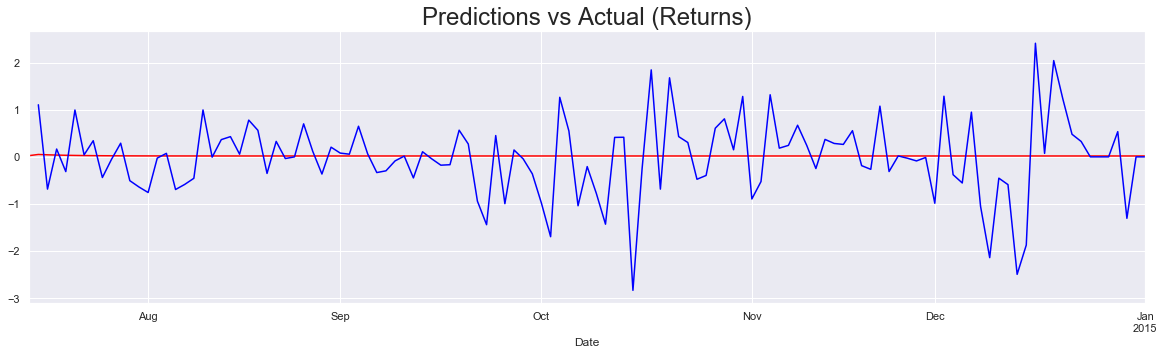

In [26]:
df_pred_arma[start_date:end_date].plot(figsize = (20, 5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()

In [27]:
df_pred_arma.head()

2014-07-15    0.026650
2014-07-16    0.051209
2014-07-17    0.043852
2014-07-18    0.038184
2014-07-21    0.033818
Freq: B, dtype: float64

## ARMAX

In [28]:
model_ret_armax = ARIMA(
    df.ret_ftse[1:],
    exog = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
    order = (1, 0, 1)
)
results_ret_armax = model_ret_armax.fit()

In [29]:
df_pred_armax = results_ret_armax.predict(
    start = start_date, end = end_date, 
    exog = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]
)

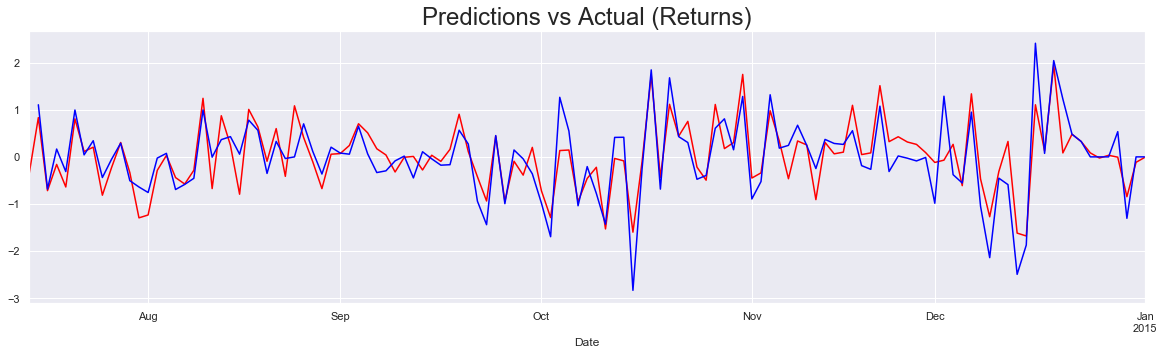

In [30]:
df_pred_armax[start_date:end_date].plot(figsize = (20, 5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title('Predictions vs Actual (Returns)', size = 24)
plt.show()
# Including outside factors improved the predictive powers drastically
# Regular ARMA models can't incorporate any outside real-world effects
# We're allowing the model to take into account data from today & past periods
# Downside of MAX models:
# They can make forecasting impossible
# forecast not equal predictions
# predictions = in-sample estimations
# forecast = out-of-sample estimations
# MAX models can be great when we're analysing data
# but poor when we're trying to forecast it